# Sparkify Project Workspace
Welcome to the Sparkify project, here you will see an analsysis of the small sparkify dataset, and models to predict user churn.

In [1]:
# EDA Plan
## 1. Defined churn
## 2. Cleaned for empty user strings, as well as user agents
## 3. Split user agent string into platform and browser (bar plot for platform and browser)
## 4. Split location column into city and state (bar plot for state)
## 5. Converted timestamp into unique day column

# Feature Engineering
## 1. Average daily sessions (boxplot)
## 2. Average daily thumbs up (boxplot)
## 3. Average daily thumbs down (boxplot)
## 4. Average daily advertisements
## 5. Average daily next song actions
## 6. Average daily error actions
## 7. Total unique artists listened to
## 8. Days passed as a user of the service

# Modeling
## 1. Preprocess data
## 2. Split into train/test
## 3. Check F1 for a few models
## 4. Use CV
## 5. Check accuracy on both train/test set

In [2]:
# import libraries
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import udf, max, min, lit, when, col, count, countDistinct
from pyspark.sql.types import *


import math
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
# create a Spark session
spark = SparkSession.builder.appName("EDA  Sparkify").getOrCreate()

In [4]:
path = "./mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [5]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
user_log.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

## *Clean Data for Missing Values*

- After taking a look at the data, I've decided to transform some of the columns

- First, I must ensure that each row has a user

In [9]:
def check_and_clean_column(df, column):
    """
    Show the users in sorted order so anomalous entries will show up at the top.
    Count before and after removing columns that have a missing entry in this column.
    """
    ### Check for anomalies in the dataset
    df.select([column]).dropDuplicates().sort(column).show()
    
    ### Filter for empty string, and print results
    print(df.count())
    df = df.filter(df[column] != "") #on the mini data 
    print(df.count())
    
    return df

In [10]:
user_log = check_and_clean_column(user_log, 'userId')

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows

286500
278154


In [11]:
user_log = check_and_clean_column(user_log, 'userAgent')

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows

278154
278154


In [12]:
user_log = check_and_clean_column(user_log, 'location')

+--------------------+
|            location|
+--------------------+
|          Albany, OR|
|Albany-Schenectad...|
|      Alexandria, LA|
|Allentown-Bethleh...|
|       Anchorage, AK|
|Atlanta-Sandy Spr...|
|Atlantic City-Ham...|
|Austin-Round Rock...|
|     Bakersfield, CA|
|Baltimore-Columbi...|
|        Billings, MT|
|Birmingham-Hoover...|
|Boston-Cambridge-...|
|         Boulder, CO|
|         Bozeman, MT|
|Bridgeport-Stamfo...|
|Buffalo-Cheektowa...|
|Charlotte-Concord...|
|Chicago-Napervill...|
|Cincinnati, OH-KY-IN|
+--------------------+
only showing top 20 rows

278154
278154


## *Observe and Define Churn*

- Taking a look at the data, then defining churn

- Checking the data afterwards, to be sure churn was implemented correctly

In [13]:
def obs_and_def_churn(df):
    """
    Take a look at the log files for rows where a user has churned.
    Flag the churn event, and then create a column that states whether or not the user ever churned.
    """
    ### Observation
    df.filter("page = 'Cancellation Confirmation'").show(5,False)
    
    ### Definition
    
    # add churn, 1 or 0
    churned = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
    df = df.withColumn("Churned", churned("page"))
    
    # add churn user flag
    df = df.withColumn("userChurned", max('Churned').over(Window.partitionBy('UserId')))
    
    return df

In [14]:
user_log = obs_and_def_churn(user_log)

+------+---------+---------+------+-------------+--------+------+-----+-------------------------------------------+------+-------------------------+-------------+---------+----+------+-------------+-------------------------------------------------------------------------------------------------------------------------------------------+------+
|artist|auth     |firstName|gender|itemInSession|lastName|length|level|location                                   |method|page                     |registration |sessionId|song|status|ts           |userAgent                                                                                                                                  |userId|
+------+---------+---------+------+-------------+--------+------+-----+-------------------------------------------+------+-------------------------+-------------+---------+----+------+-------------+--------------------------------------------------------------------------------------------------------------

In [15]:
### Double check that values make sense
print(user_log.filter(user_log['userChurned'] == 1).count())
print(user_log.filter(user_log['Churned'] == 1).count())

44864
52


## *Convert Data Prepared in Cleaning Step*

- Since we ensured there were no missing values for user agent and location, let's split columns into more useful columns
- User Agent: Converts to a browser and platform column
- Location: Converts to a city and state column

In [16]:
### Let's take a look at the available platforms for creating our UDFs
ua_list = user_log.select(['userAgent']).collect()

ua_list = [re.search(r'\(([^\)]*)\)', str(i[0]) )[0].split(';')[0].replace('(', '').replace(')', '') for i in ua_list]
ua_list = list(dict.fromkeys(ua_list))
print(ua_list)

['Windows NT 6.1', 'Macintosh', 'Windows NT 6.0', 'Windows NT 6.2', 'iPhone', 'Windows NT 6.3', 'iPad', 'compatible', 'X11', 'Windows NT 5.1']


In [17]:
### Create necessary functions for UDFs

def get_platform(x):
    """
    Checks UA String for possible platforms that are referenced within the string.
    """
    if 'compatible' in x:
        return 'Windows'
    elif 'iPad' in x:
        return 'iPad'
    elif 'iPhone' in x:
        return 'iPhone'
    elif 'Macintosh' in x:
        return 'Mac'
    elif 'Windows NT 5.1' in x:
        return 'Windows'
    elif 'Windows NT 6.0' in x:
        return 'Windows'
    elif 'Windows NT 6.1' in x:
        return 'Windows'
    elif 'Windows NT 6.2' in x:
        return 'Windows'
    elif 'Windows NT 6.3' in x:
        return 'Windows'
    elif 'X11' in x:
        return 'Linux'
    
def get_browser(x):
    """
    Checks UA String for possible browsers that are referenced within the string.
    """
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN

In [18]:
### Create UDFs, and add columns with them
get_browser_udf = udf(get_browser, StringType())
get_platform_udf = udf(get_platform, StringType())

# Adding Columns
user_log = user_log.withColumn( 'browser', get_browser_udf(user_log.userAgent) )
user_log = user_log.withColumn( 'platform', get_platform_udf(user_log.userAgent) )

In [19]:
### Doing the same with location data
def get_state(x):
    """
    Splits ccolumn values on a ", " and retrieves the state entry.
    """
    return x.split(', ')[1]

def get_city(x):
    """
    Splits column values on a ", " and retrieves the city entry.
    """
    return x.split(', ')[0]

In [20]:
get_state_udf = udf(get_state, StringType())
get_city_udf = udf(get_city, StringType())

user_log = user_log.withColumn( 'state', get_state_udf(user_log.location) )
user_log = user_log.withColumn( 'city', get_city_udf(user_log.location) )

## *Visualize Converted Data with Bar Plots*

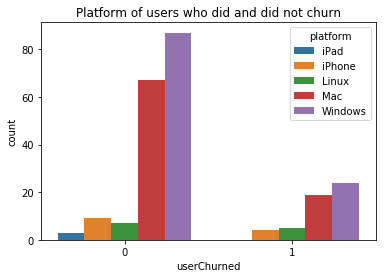

In [21]:
churned_platform_group = user_log.drop_duplicates(['userId', 'platform']).groupby(['userChurned', 'platform']).count().sort("userChurned").toPandas()

plt.figure()
plt.title('Platform of users who did and did not churn')
sb.barplot( x = 'userChurned', y = 'count', data = churned_platform_group, hue = 'platform' )
plt.show()

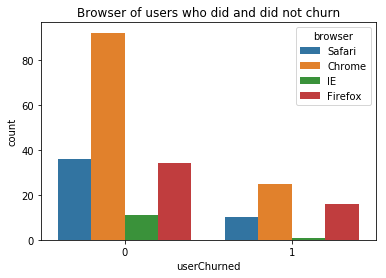

In [22]:
churned_platform_group = user_log.drop_duplicates(['userId', 'browser']).groupby(['userChurned', 'browser']).count().sort("userChurned").toPandas()

plt.figure()
plt.title('Browser of users who did and did not churn')
sb.barplot( x = 'userChurned', y = 'count', data = churned_platform_group, hue = 'browser' )
plt.show()

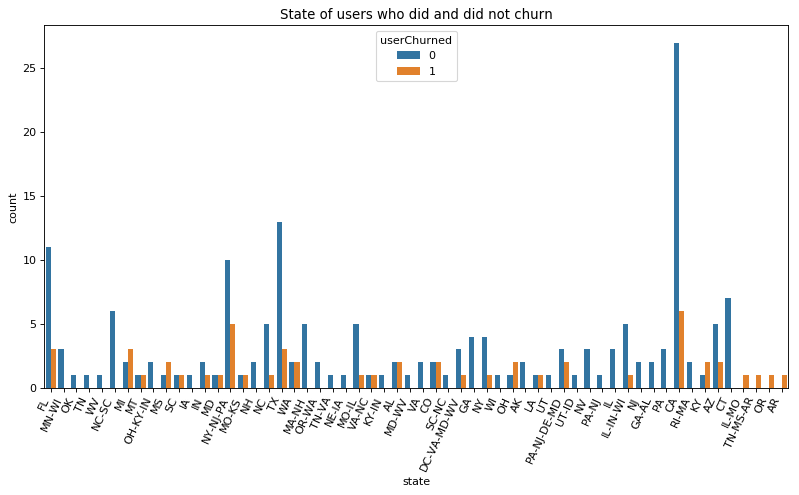

In [23]:
churned_state_group = user_log.drop_duplicates(['userId', 'state']).groupby(['userChurned', 'state']).count().sort("userChurned").toPandas()

plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('State of users who did and did not churn')
sb.barplot( x = 'state', y = 'count', data = churned_state_group, hue = 'userChurned' )
plt.xticks(rotation=65, horizontalalignment='right')
plt.show()

## *Engineer and Visualize Daily Data*

- Create column for unique day
- Visualize avg daily sessions
- Visualize avg daily page events

In [24]:
### Create unique day column from timestamp
get_hour = udf(lambda x: math.floor( (x / 1000.0) / (60*60*24) ) )
user_log = user_log.withColumn("uniqueDay", get_hour(user_log.ts))

In [25]:
total_daily_sessions_df = user_log.select('userId', 'sessionId', 'uniqueDay').groupby(['userId', 'uniqueDay']).agg(count('sessionId').alias('totalDailySessions')).sort('userId')
avg_daily_sessions_df = total_daily_sessions_df.groupBy('userId').avg('totalDailySessions').withColumnRenamed('avg(totalDailySessions)', 'avgDailySessions')

user_log = user_log.join(total_daily_sessions_df, on=['userId', 'uniqueDay'])
user_log = user_log.join(avg_daily_sessions_df, on='userId')

In [26]:
### Let's take a look at the page interaction options
print(user_log.select(['page']).dropDuplicates().sort('page').show())

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+

None


In [27]:
def create_avg_daily_page_interaction_column(df, page_interaction, page_title):
    """
    Creates a column that counts the number of times a user interacted with a certain page, in a given day.
    Then, the avg daily value is computed from the total, and joined with the dataframe.
    """
    total_daily_df = df.select('userId', 'page', col('uniqueDay').alias('uniqueDay')).groupby(['userId', 'uniqueDay']).agg(count(when(col("page") == page_interaction, 1)).alias('totalDaily' + page_title)).sort('userId')
    avg_dailydf = total_daily_df.groupBy('userId').avg('totalDaily' + page_title).withColumnRenamed('avg(totalDaily' + page_title + ')', 'avgDaily' + page_title)

    df = df.join(avg_dailydf, on='userId')
    
    return df
    

In [28]:
user_log = create_avg_daily_page_interaction_column(user_log, 'Thumbs Up', 'ThumbsUp')
user_log = create_avg_daily_page_interaction_column(user_log, 'Thumbs Down', 'ThumbsDown')
user_log = create_avg_daily_page_interaction_column(user_log, 'Error', 'Errors')
user_log = create_avg_daily_page_interaction_column(user_log, 'Roll Advert', 'Advertisements')
user_log = create_avg_daily_page_interaction_column(user_log, 'NextSong', 'NextSong')

In [34]:
def visualize_box_and_whisker(df, column):
    """
    For a given column, this generates a box and whisker plot, splitting the user data between those who did or did not churn.
    """
    avg_daily_pd = user_log.select(['userId', col(column).alias(column),'userChurned']).drop_duplicates(['userId']).sort("userChurned").toPandas()

    plt.figure()
    sb.boxplot(y=column, x="userChurned", data=avg_daily_pd)
    plt.title(column + ' between users who did or did not churn')
    plt.show()

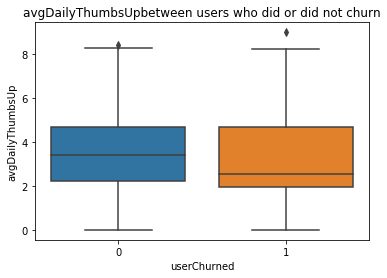

In [35]:
visualize_box_and_whisker('user_log', 'avgDailyThumbsUp')

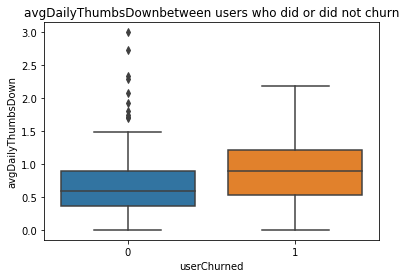

In [36]:
visualize_box_and_whisker('user_log', 'avgDailyThumbsDown')

## *Additional Informative Columns (Not Page Interactions)*

In [37]:
total_distinct_artists_df = user_log.select('userId', 'artist').groupby('userId').agg(countDistinct('artist')).withColumnRenamed('count(DISTINCT artist)', 'totalDistinctArtists')
user_log = user_log.join(total_distinct_artists_df, on='userId')


duration_using_service_df = user_log.select('userId', 'uniqueDay').groupby('userId').agg(max('uniqueDay') - min('uniqueDay')).withColumnRenamed('(max(uniqueDay) - min(uniqueDay))', 'durationUsingService')
user_log = user_log.join(duration_using_service_df, on='userId')

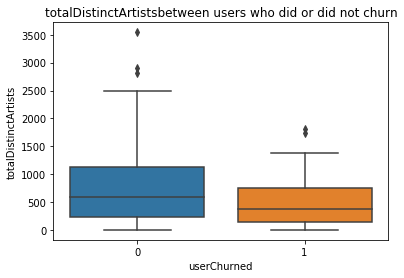

In [38]:
visualize_box_and_whisker('user_log', 'totalDistinctArtists')

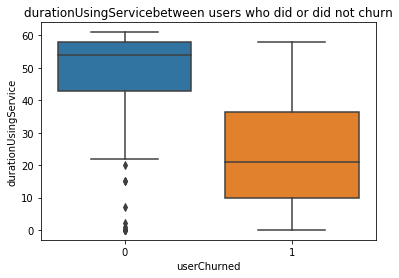

In [39]:
visualize_box_and_whisker('user_log', 'durationUsingService')

## *Select Features and Prepare Model*

- Drop unnecessary columns
- Drop duplicate user ID files, in order to predict churned values for each user

In [40]:
user_log.printSchema()

# level (cat)
# browser (cat)
# platform (cat)
# state (cat)
# city (cat)
# avgDailySessions (num)
# avgDailyThumbsUp (num)
# avgDailyThumbsDown (num)
# avgDailyErrors (num)
# avgDailyAdvertisements (num)
# avgDailyNextSong (num)
# totalDistinctArtists (num)
# durationUsingService (num)

root
 |-- userId: string (nullable = true)
 |-- uniqueDay: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- Churned: integer (nullable = true)
 |-- userChurned: integer (nullable = true)
 |-- browser: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- totalDailySessions: long

In [41]:
user_log = user_log.drop('artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'location', 'method', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'Churned', 'uniqueDay', 'page')

user_log = user_log.dropDuplicates(['userId'])


In [42]:
def transform_features_pipeline(df):
    """
    This pipeline vectorizes all of the features, for use in prediction.
    Leverages StringIndexer for categorical data, and VectorAssembler for numerical data.
    Once the categorical variables are indexed, and the numerical data is scaled, VectorAssembler is run again to combine all of the results.
    """
    ### Create pipeline for processing data
    # Categorical Data
    pipeline_stages = [StringIndexer(inputCol=column, outputCol=column+"Index") 
                        for column in ['level','browser', 'platform', 'state', 'city'] ]

    # Numerical Data
    assembler = VectorAssembler(inputCols=['avgDailySessions', 'avgDailyThumbsUp', 'avgDailyThumbsDown', 'avgDailyErrors', 'avgDailyAdvertisements', 'avgDailyNextSong', 'totalDistinctArtists', 'durationUsingService'], outputCol="features")
    pipeline_stages.append(assembler)

    standard_scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
    pipeline_stages.append(standard_scaler)

    # Categorical and Numerical Data
    combined_assembler = VectorAssembler(inputCols=['scaledFeatures','levelIndex', 'browserIndex', 'platformIndex', 'stateIndex', 'cityIndex'], outputCol='combinedFeatures')

    pipeline_stages.append(combined_assembler)

    process_pipeline = Pipeline(stages=pipeline_stages)
    
    ### Fit and transform the df into features
    
    df_model = process_pipeline.fit(df).transform(df)

    df_model = df_model.select('userChurned','combinedFeatures').withColumnRenamed('userChurned', 'label')
    
    return df_model
    
    

In [43]:
user_log_model = transform_features_pipeline(user_log)

## *Split Training and Test Data*

- Cache the values to ensure driver does not run out of memory

In [44]:
train, test = user_log_model.randomSplit([0.8, 0.2], seed=42)

train.cache()
test.cache()

DataFrame[label: int, combinedFeatures: vector]

In [45]:
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
auc_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

def check_model_f1(model, train, test):
    """
    Fits the supplied model, and then evaluates accuracy through the F1 score, and area under ROC.
    """
    fitted_model = model.fit(train)
    model_results = fitted_model.transform(test)
    
    f1_score = f1_evaluator.evaluate(model_results.select(col('label'), col('prediction')))
    
    print('The F1 score on the test set is {:.2%}'.format(f1_score)) 
    
    roc_value = auc_evaluator.evaluate(model_results)
    
    print('The areaUnderROC on the test set is {:.2%}'.format(roc_value))

In [46]:
log_reg = LogisticRegression(featuresCol="combinedFeatures", labelCol="label", maxIter=10)
gbt = GBTClassifier(featuresCol="combinedFeatures", labelCol="label", maxIter=10, maxBins=120)
rf = RandomForestClassifier(featuresCol="combinedFeatures", labelCol="label", maxBins=120)


In [47]:
check_model_f1(log_reg, train, test)

The F1 score on the test set is 70.31%
The areaUnderROC on the test set is 86.25%


In [49]:
check_model_f1(gbt, train, test)

The F1 score on the test set is 60.27%
The areaUnderROC on the test set is 72.71%


In [50]:
check_model_f1(rf, train, test)

The F1 score on the test set is 71.70%
The areaUnderROC on the test set is 79.17%


## *Improve Best Model with CrossValidator*

In [55]:
log_reg = LogisticRegression(featuresCol="combinedFeatures", labelCol="label")

log_reg_param_grid = ParamGridBuilder().addGrid(log_reg.elasticNetParam, [0, 0.5]).addGrid(log_reg.maxIter, [10, 50]).build()
cross_validator = CrossValidator(estimator = log_reg, estimatorParamMaps = log_reg_param_grid, evaluator = MulticlassClassificationEvaluator(metricName='f1'), numFolds = 3)

In [56]:
cv_model = cross_validator.fit(train)
cv_test_results = cv_model.transform(test)
cv_train_results = cv_model.transform(train)

In [57]:
f1_score_train = f1_evaluator.evaluate(cv_test_results.select(col('label'), col('prediction')))
print('The F1 score on the training set for the hypertuned log model is {:.2%}'.format(f1_score_train)) 

f1_score_test = f1_evaluator.evaluate(cv_train_results.select(col('label'), col('prediction')))
print('The F1 score on the test set for the hypertuned log model is {:.2%}'.format(f1_score_test))

The F1 score on the training set for the hypertuned log model is 79.55%
The F1 score on the test set for the hypertuned log model is 86.47%


In [58]:
roc_train_value = auc_evaluator.evaluate(cv_train_results)
print('The areaUnderROC on the training set for the hypertuned log model is {:.2%}'.format(roc_train_value))

roc_test_value = auc_evaluator.evaluate(cv_test_results)
print('The areaUnderROC on the test set for the hypertuned log model is {:.2%}'.format(roc_test_value))

The areaUnderROC on the training set for the hypertuned log model is 88.99%
The areaUnderROC on the test set for the hypertuned log model is 87.92%


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

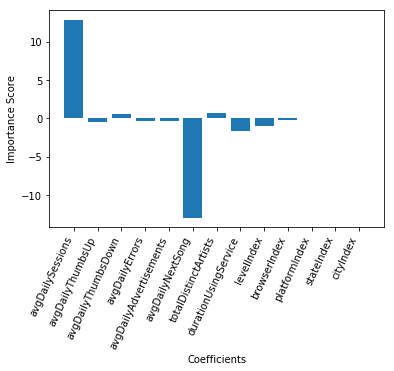

In [59]:
cv_feature_vals = cv_model.bestModel.coefficients
feature_cols = ['avgDailySessions', 'avgDailyThumbsUp', 'avgDailyThumbsDown', 'avgDailyErrors', 'avgDailyAdvertisements', 'avgDailyNextSong', 'totalDistinctArtists', 'durationUsingService','levelIndex', 'browserIndex', 'platformIndex', 'stateIndex', 'cityIndex']

x_pos = np.arange(len(feature_cols))
 
plt.bar(x_pos, cv_feature_vals, align='center')
plt.xticks(x_pos, feature_cols)
plt.ylabel('Importance Score')
plt.xlabel('Coefficients')
plt.xticks(rotation=65, horizontalalignment='right')

## Further Steps
* Run these steps on a hadoop cluster to see how the models perform on the large dataset
* Include more metrics about the user that are weekly/monthly
* Define a user journey to count: say the user hits next song, receives an advertisement, and then logs out. Or times where a user listened to more than 10 songs in a session, for example.